In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from local_feature_tutorial.wbs import *
from local_feature_tutorial.visualization import *
from local_feature_tutorial.io import *
from local_feature_tutorial.datasets import *
from wbs_tutorial.SP import *
import cv2
from copy import deepcopy
import shlex
#export
import pydegensac
class degensac_VerifierH(GeometricVerifier):
    def __init__(self, th = 0.5):
        self.th = th
        return
    def verify(self, srcPts:np.array, dstPts:np.array):
        F, mask = pydegensac.findHomography(srcPts, dstPts, self.th, 0.999, max_iters=250000)
        return F, mask


In [2]:
fname1='/home/old-ufo/paid_projects/tasq_ai/tower examples/tower_seq1/DJI_0009_TeAYwt3a-wCSKfW9O.JPG'
fname2='/home/old-ufo/paid_projects/tasq_ai/tower examples/tower_seq1/DJI_0010_UXQrY3JX-agz6r16y.JPG'
fname3='/home/old-ufo/paid_projects/tasq_ai/tower examples/tower_seq1/DJI_0011_iS6YFigJ-SUSNvUG7.JPG'


In [3]:
#sg_matcher = SuperGlueTwoViewMatcher(geom_verif=degensac_VerifierH(1.0))
fn1 = fname1
fn2 = fname2
fn3 = fname3



resized1.jpg


In [2]:
sift_matcher = TwoViewMatcher(detector=cv2.SIFT_create(8000, edgeThreshold=10000), 
                              descriptor=HardNetDesc(),
                              matcher= SNNMMatcher(0.95),
                              geom_verif=degensac_Verifier(0.5))


In [19]:
fn1 = '/home/old-ufo/datasets/tree/tree_in_colmap/set_100/images/IMG_9614.MOV_frame000504.jpg'
fn2 = '/home/old-ufo/datasets/tree/tree_in_colmap/set_100/images/IMG_9614.MOV_frame000502.jpg'


In [20]:

res1 = sift_matcher.verify(fn1,fn2)
F12 = deepcopy(res1['F'])


In [5]:
res1.keys()

dict_keys(['match_kpts1', 'match_kpts2', 'F', 'num_inl', 'tentative_pts1', 'tentative_pts2'])

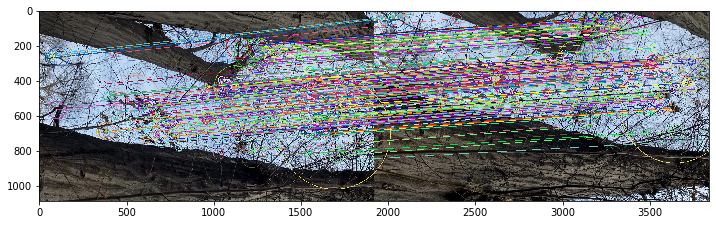

In [27]:
draw_matches(res1['match_kpts1'], res1['match_kpts2'],
            cv2.cvtColor(cv2.imread(fn1), cv2.COLOR_BGR2RGB),
            cv2.cvtColor(cv2.imread(fn2), cv2.COLOR_BGR2RGB), R=10, vert=False)


In [22]:

import json
from jsmin import jsmin
import cv2
import h5py
import numpy as np


def load_h5(filename):
    '''Loads dictionary from hdf5 file'''

    dict_to_load = {}
    try:
        with h5py.File(filename, 'r') as f:
            keys = [key for key in f.keys()]
            for key in keys:
                dict_to_load[key] = f[key][()]
    except:
        print('Cannot find file {}'.format(filename))
    return dict_to_load

def load_calib(calib_fullpath_list, subset_index=None):
    '''Load all calibration files and create a dictionary.'''

    calib = {}
    if subset_index is None:
        for _calib_file in calib_fullpath_list:
            img_name = os.path.splitext(
                os.path.basename(_calib_file))[0].replace('calibration_', '')
            # _calib_file.split(
            #     '/')[-1].replace('calibration_', '')[:-3]
            # # Don't know why, but rstrip .h5 also strips
            # # more then necssary sometimes!
            # #
            # # img_name = _calib_file.split(
            # #     '/')[-1].replace('calibration_', '').rstrip('.h5')
            calib[img_name] = load_h5(_calib_file)
    else:
        for idx in subset_index:
            _calib_file = calib_fullpath_list[idx]
            img_name = os.path.splitext(
                os.path.basename(_calib_file))[0].replace('calibration_', '')
            calib[img_name] = load_h5(_calib_file)
    return calib

In [23]:
with open ('/home/old-ufo/datasets/tree/tree_in_colmap/set_100/calibration.txt', 'r') as f:
    fnames = f.readlines()
fnames = ['/home/old-ufo/datasets/tree/tree_in_colmap/set_100/' + f.strip() for f in fnames]

In [10]:
fnames = sorted(list(set(fnames)))

In [11]:
import os
calib = load_calib(fnames)

In [24]:
cal1 = calib['IMG_9614.MOV_frame000504']
cal2 = calib['IMG_9614.MOV_frame000502']


In [25]:
from utils import *
pts1 = np.array([x.pt for x in res1['match_kpts1']])
pts2 = np.array([x.pt for x in res1['match_kpts2']])


In [14]:
def eval_essential_matrix2(p1n, p2n, E, dR, dt):
    if len(p1n) != len(p2n):
        raise RuntimeError('Size mismatch in the keypoint lists')

    if p1n.shape[0] < 5:
        return np.pi, np.pi / 2

    if E.size > 0:
        _, R, t, _ = cv2.recoverPose(E, p1n, p2n)
        print (R,'\n', dR)
        try:
            err_q, err_t = evaluate_R_t(dR, dt, R, t)
        except:
            err_q = np.pi
            err_t = np.pi / 2

    else:
        err_q = np.pi
        err_t = np.pi / 2

    return err_q, err_t

In [26]:
K1 = cal1['K']
K2 = cal2['K']

E_cv_from_F = get_E_from_F(res1['F'], K1, K2)
print (f'E = {E_cv_from_F}')
R1 =cal1['R']
R2 = cal2['R']
T1 = cal1['T'].reshape((3, 1))
T2 = cal2['T'].reshape((3, 1))
dR = np.dot(R2, R1.T)
dT = T2 - np.dot(dR, T1)
p1n = normalize_keypoints(pts1, K1)
p2n = normalize_keypoints(pts2, K2)
err = max(eval_essential_matrix2(p1n, p2n, E_cv_from_F, dR, dT))
print (np.rad2deg(err))

E = [[ 0.07449475  0.19431918 -4.01057084]
 [-0.5457611  -0.03392481 -0.75255326]
 [ 4.02304159  0.5054582   0.00953938]]
[[ 0.99808941 -0.05932681  0.01725858]
 [ 0.06062641  0.99423891 -0.0883936 ]
 [-0.01191504  0.08927105  0.9959361 ]] 
 [[ 9.99156544e-01  1.10626842e-03 -4.10484736e-02]
 [-6.57628113e-04  9.99939925e-01  1.09414185e-02]
 [ 4.10581117e-02 -1.09051953e-02  9.99097247e-01]]
76.87104345212049


In [14]:
#match all to all and keep both points